# ДЗ 2 по CV

## Задание.
В этом домашнем задании вам необходимо имплементировать процедуру обучения WGAN. В качестве датасета предлагается использовать fashion mnist.


## План решения.

Для решения я планирую на примере датасета с FashionMNIST посмотреть генерации:
- линейный "ванильный" GAN
- "ванильный" GAN на сверточных сетях DCGAN
- WGAN с клиппингом весов
- WGAN со штрафами на градиент
- **WGAN со штрафами на градиент и условной генерацией - текущий ноутбук**

Использовать будут библиотеку pytorch-lightning, так как давно хотела ее попробовать и решила использовать для этого задания.
Подгружать буду результаты по loss + генерируемые картинки на wandb. Проект для задания - публичный, результаты по всем экспериментам доступны по ссылке в ноутбуке. Дополнительно в выводах добавлю принт-скрин с run from wandb.

Обучать все варианты GAN буду на 20 эпохах, чтобы сравнить и скорость обучения и качество генераций.

Все эксперименты подгружу в один проект, чтобы можно было посмотреть качество генераций по всем сразу. Loss скорее всего будут разные.

При решении задачи вдохновлялась следующим кодом:

- https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs
- https://github.com/nocotan/pytorch-lightning-gans/tree/master
- https://lightning.ai/docs/pytorch/2.1.0/notebooks/lightning_examples/basic-gan.html

<hr>

WGAN со штрафом на градиент трансформируется в условный генератор. По окончании каждой эпохи буду генерировать следующие картинки:

- 0 - футболка
- 1 - брюки
- 2 - пуловер
- 9 - ботинки
- 4 - пальто
- 8 - сумка

Основное изменение - labels добавляются в качестве эмбединнгов (как дополнительный канал) в изображение в прямых проходах и генератора, и дискриминатора.

<hr>

### Шаг 1. Устанавливаем библиотеки

In [1]:
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
random_seed = 42
torch.manual_seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE=64
CHANNELS_IMG = 1
IMAGE_SIZE = 64
FEATURES_DISC = 64
FEATURES_GEN = 64
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
N_CRITIC = 20
LAMBDA_GP = 10
NUM_CLASSES = 10
GEN_EMBEDDING = 100

### Шаг 2. Загружаем данные
Для этого воспользуюсь DataModule из lightning и на его основе создам класс.

In [3]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=1):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.Resize(IMAGE_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
                ),
            ]
        )


    def prepare_data(self):
        FashionMNIST(self.data_dir, train=True, download=True)
        FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = FashionMNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [60000, 0])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = FashionMNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)


### Шаг 3. Создаем Discriminator
Это бинарный классификатор на основе линейных слоев, основная здача которого определять является полученное от генератора изображение настоящим или поддельным. Используюися сверстки для снижения размерности изображения с 64х64 до 1х1.

Так как это WGAN, то не используется сигмоида в конце сети, так как выходные данные уже не будут бинарными. Теперь дискриминатор будет сравнивать распределения.

Также заменили BatchNorm to InstanceNorm, так как не нужна нормализация по батчам.

Для создания условного WGAN добавляются эмбединг, img_size x img_size в forward. Такое добавление можно считать похожим на добавление дополнительного канала. Исходное изображение concat с добавленным эмбедингом. Увеличивается кол-во входных каналов на 1, чтобы добавить labels для генерации по условию.

In [4]:
# Detective: fake or no fake -> 1 output [0, 1] not in WGAN
# add labels as emdeddings
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super().__init__()
        self.image_size = img_size
        self.disc = nn.Sequential(
            #Input size N x channels_img x 64 x64
            nn.Conv2d(
                channels_img+1, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4,2,1),#16x16
            self._block(features_d*2, features_d*4, 4,2,1),#8x8
            self._block(features_d*4, features_d*8, 4,2,1),#4x4
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), #1x1
            #nn.Sigmoid(),
        )
        self.embed = nn.Embedding(num_classes, img_size*img_size)
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
          return nn.Sequential(
              nn.Conv2d(
                  in_channels,
                  out_channels,
                  kernel_size,
                  stride,
                  padding,
                  bias = False,
              ),
              nn.InstanceNorm2d(out_channels, affine = True), #change BatchNorm to InstanceNorm ->LayerNorm as in paper
              nn.LeakyReLU(0.2),
          )


    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 1, self.image_size, self.image_size)
        x = torch.cat([x, embedding], dim=1) 
        return self.disc(x)

### Шаг 4. Создаем генератор картинок из шума
Используются слои ConvTranspose2d, которые обратны свертке. В результате размерность изображения повышается до 64х64.

Добавляем также labels в качестве эмбедингов, но уже к шуму, используя дополнительный параметр embed_size. В forward в итоге добавляются размерности. Сгенерированное изображение также конкатенируется с этим эмбедигом. Увелчивается кол-во каналов для шума на 1.

In [5]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, 
                 latent_dim,
                 channels_img,
                 features_g,
                 num_classes, 
                 img_size,
                 embed_size,
                ):
        super().__init__()
        self.img_size = img_size
        self.gen = nn.Sequential(
            self._block(latent_dim+embed_size, features_g*16, 4, 1, 0), # N x latent_dim
            self._block(features_g*16, features_g*8, 4, 2, 1), #8x8
            self._block(features_g*8, features_g*4, 4, 2, 1), #16x16
            self._block(features_g*4, features_g*2, 4, 2, 1), #32x32
            nn.ConvTranspose2d(features_g*2,
                               channels_img,
                               kernel_size=4,
                               stride =2,
                               padding=1
                               ),
            nn.Tanh()
        )
        self.embed = nn.Embedding(num_classes, embed_size)
        

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
                  nn.ConvTranspose2d(
                      in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding,
                      bias = False,
                  ),
                  nn.BatchNorm2d(out_channels),
                  nn.ReLU(),
        )


    def forward(self, x, labels):
        # N x noise dim x 1 x 1
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.gen(x)

In [6]:
def initialize_weights(model):
      for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
              nn.init.normal_(m.weight.data, 0.0, 0.02)

### Шаг 5. Соединяем дискриминатор и генератор в единую сеть
Это необязательное соединение, но мне показалось так будет понятее и так рекомендуется в библиотеке lightning. В методах дополнительно определяем:
- функцию потерь  и добавление к ней штрафа с учетом параметра lambda
- оптимизаторы отдельно для дискриминатора и генератора. Для обеспечения более частого обучения дискриминатора с параметром N_CRITIC я воспользовалась настройками оптимизатора (см. ниже по коду), но пока не до конца поняла работает эта настройка или нет. Может быть имело бы смысл сделать ручной цикл обучения, но тогда не нужен был бы lightining.
- порядок обучения (обучение без учителя)
- добавляем функцию для расчета штрафа на градиент gradient_penalty, котораяа будет использовать интерполяцию изображений с рандомным коффициентом epsilon. Это объединенное изображение попадает в дискриминатор и рассчитявает скор и используется для расчета штрафа. Labels добавляются также в эту функцию.
- генерацию валидационного сета по окончании каждой эпохи и его прогрузку в wandb. Добавялем условие (номер класса) для генерации, описанное выше в первом пункте.


In [7]:
class GAN(pl.LightningModule):
    def __init__(self,
                 latent_dim=100,
                 lr=LEARNING_RATE,
                 b1: float = 0.0,
                  b2: float = 0.9,
                  batch_size: int = BATCH_SIZE,
                  **kwargs,):
        super().__init__()
        self.automatic_optimization = False
        self.save_hyperparameters()

        self.generator = Generator(latent_dim=self.hparams.latent_dim,
                                   channels_img=CHANNELS_IMG,
                                   features_g = FEATURES_GEN,
                                    num_classes = NUM_CLASSES, 
                                    img_size = IMAGE_SIZE,
                                    embed_size = GEN_EMBEDDING)
        self.discriminator = Discriminator(channels_img = CHANNELS_IMG,
                                           features_d = FEATURES_DISC,
                                          num_classes = NUM_CLASSES, 
                                           img_size = IMAGE_SIZE
                                           )

        initialize_weights(self.generator)
        initialize_weights(self.discriminator)

        #random noise
        self.validation_z = torch.rand(6, self.hparams.latent_dim, 1, 1)

    def forward(self, z, labels):
        return self.generator(z, labels)
    
    def gradient_penalty(self, labels, real, fake, device):
          BATCH_SIZE, C, H, W = real.shape
          epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
          interpolated_images = (real * epsilon + fake * (1 - epsilon)).requires_grad_(True)
          interpolated_images = interpolated_images.to(device)

          # calculate discriminator's score
          mixed_scores = self.discriminator(interpolated_images, labels)

          gradient = torch.autograd.grad(
              inputs = interpolated_images,
              outputs = mixed_scores,
              grad_outputs = torch.ones_like(mixed_scores),
              create_graph=True,
              retain_graph = True,
              
          )[0]

          gradient = gradient.view(gradient.shape[0], -1).to(device) #flatten all other dim
          gradient_norm = gradient.norm(2, dim=1) #L2 regularization
          gp = torch.mean((gradient_norm - 1) ** 2)
          return gp

    #def adversarial_loss(self, y_hat, y):
        #return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch):
        opt_g, opt_d = self.optimizers()
        real_imgs, labels = batch
                
        #sample noise
        z = torch.rand(real_imgs.shape[0], self.hparams.latent_dim, 1, 1)
        z = z.type_as(real_imgs)
        
        #train generator max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        self.toggle_optimizer(opt_g)
        fake_imgs = self(z, labels)
        y_hat = self.discriminator(fake_imgs, labels).reshape(-1)
        g_loss = - torch.mean(y_hat)

        self.log("g_loss", g_loss, prog_bar=True)
        self.manual_backward(g_loss)
        opt_g.step()
        opt_g.zero_grad()
        self.untoggle_optimizer(opt_g)


        # train discriminator max E[critic(real)] - E[critic(fake)]
        self.toggle_optimizer(opt_d)

        y_hat_real = self.discriminator(real_imgs, labels).reshape(-1)
        y_hat_fake = self.discriminator(self(z, labels).detach(), labels).reshape(-1)
        gp = self.gradient_penalty(labels = labels, 
                                   real=real_imgs,
                                  fake=self(z, labels).detach(),
                                  device=device)
           
        d_loss = (-(torch.mean(y_hat_real) - torch.mean(y_hat_fake)))  + LAMBDA_GP * gp
            
        self.log("d_loss", d_loss, prog_bar=True)
        
        self.manual_backward(d_loss, retain_graph=True)
        opt_d.step()
        opt_d.zero_grad()
        self.untoggle_optimizer(opt_d)


    #change optimizers to RMSProp — root mean square propagation
    def configure_optimizers(self):
        n_critic = N_CRITIC

        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas = (b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas = (b1, b2))
        return (
            {'optimizer': opt_g, 'frequency': 1},
            {'optimizer': opt_d, 'frequency': n_critic}
        )


    def on_train_epoch_end(self):
        z = self.validation_z.to(device)
        labels = torch.tensor([0,1,2,9,4,8]).to(device)

        # log sampled images
        sample_imgs = self(z, labels)
        grid_fake = torchvision.utils.make_grid(sample_imgs, normalize=True)
        self.logger.experiment.add_image("generated_images", grid_fake, self.current_epoch)
        

### Шаг6. Подключаемся к wandb и создаем проект

In [8]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
wandb.init(project="GAN_fin", sync_tensorboard=True)

wandb: Currently logged in as: katya_shakhova (shakhova). Use `wandb login --relogin` to force relogin


In [11]:
dm = MNISTDataModule()
model = GAN()

In [12]:
trainer = pl.Trainer(max_epochs= NUM_EPOCHS, accelerator="auto")
trainer.fit(model, dm)

100%|██████████| 26421880/26421880 [00:03<00:00, 8633679.21it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 136123.75it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2526611.14it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6346936.21it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/core/optimizer.py:375: Found unsupported keys in the optimizer configuration: {'frequency'}
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

In [13]:
wandb.finish()

d_loss,▁▇▇▇▇███████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
g_loss,█▇▆▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
hp_metric,▁
d_loss,-1.31244
epoch,19.0
g_loss,-57.48328
global_step,18749
hp_metric,-1.0


# Выводы

Интересно, что модель начала генерировать правильные картинки по условию уже на самых ранних шагах обучения, последовательно улучшая качество:

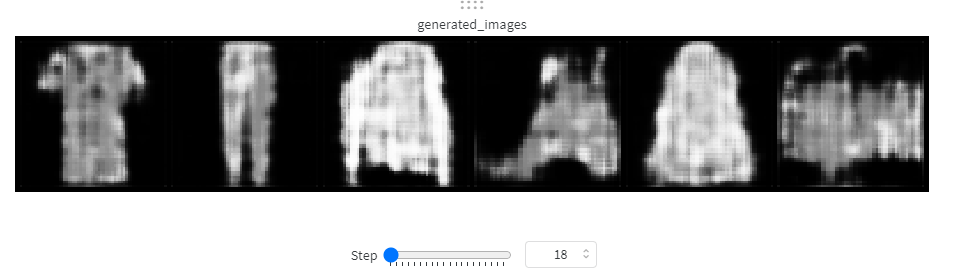
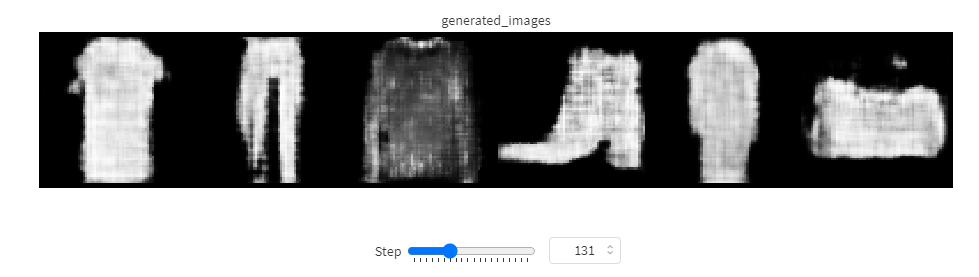
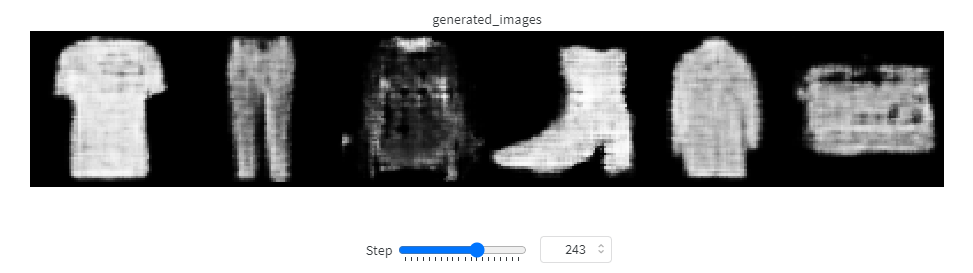

При этом обучение шло значительно быстрее, чем в предыдущем варианте без labels. Качество осталось неплохим, но такого кол-ва эпох точно не нужно было. На последней эпохе качество генерации ухудшилось, поэтому на принт-скрине ниже - предпоследняя эпоха.

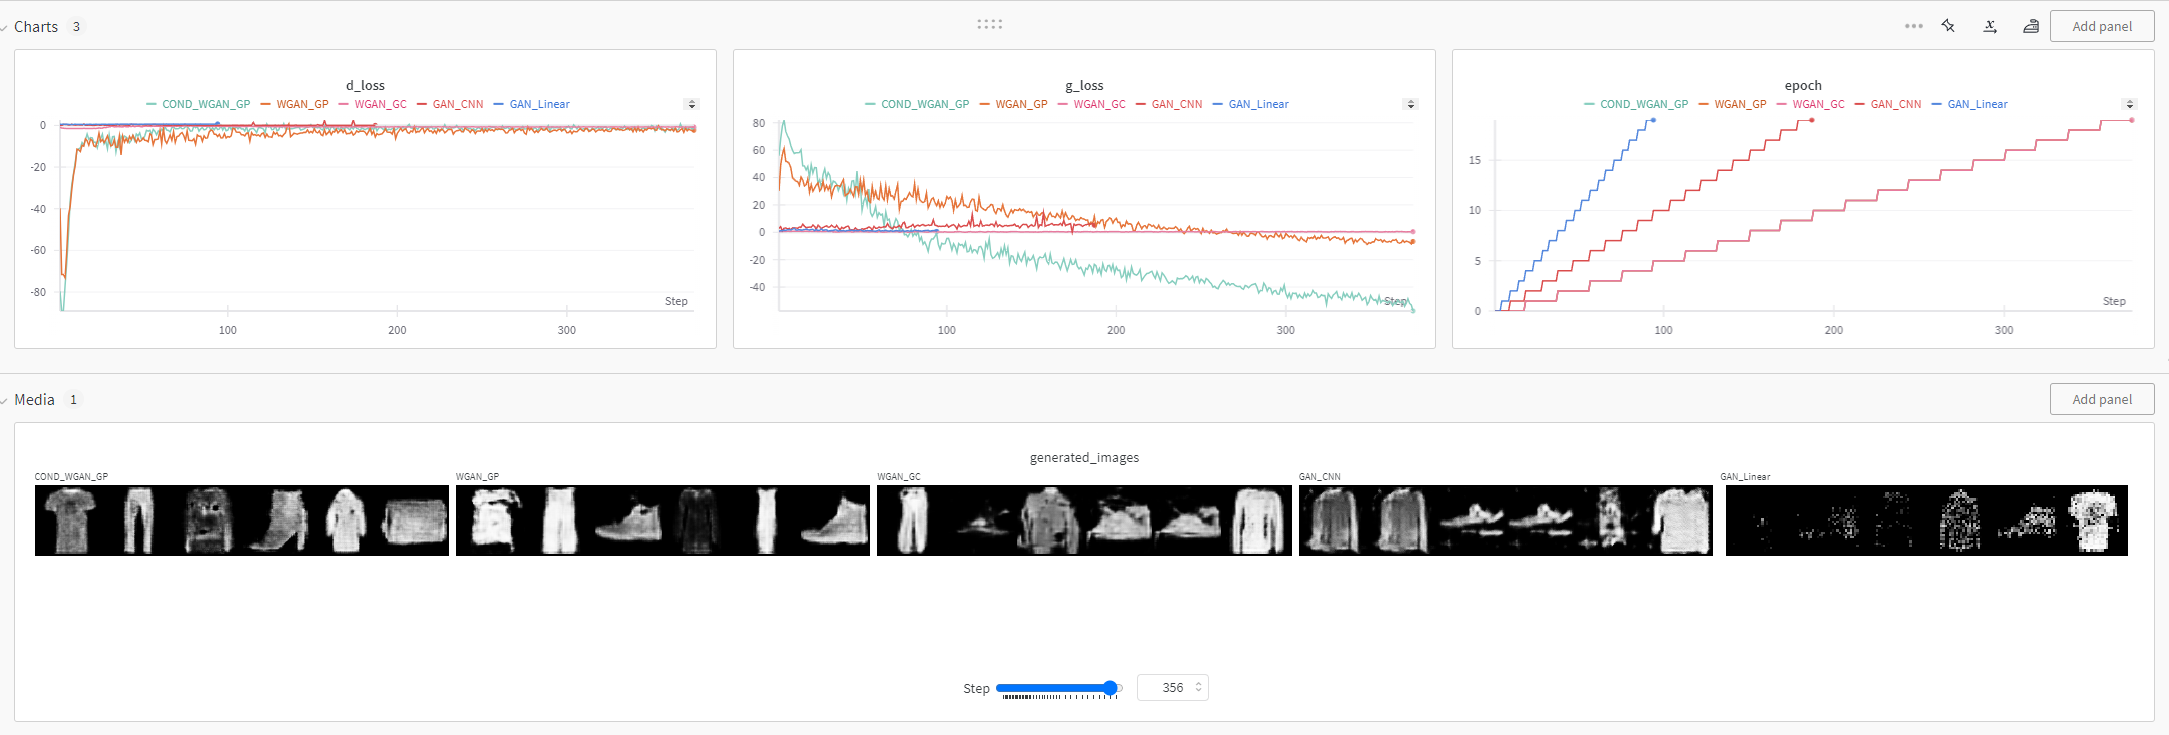

Напоследок, хотелось бы сравнить методы по использованию GPU (на кратинке ниже). Для условной генерации может сыграла роль, что все предыдущее сети я обучала в Colab, но закончились ресурсы и пришлось перейти в Kaggle. Я не ожидала увидеть такой разницы в ресурсах, но не исключено, что это обучение реально более затратное, хотя прошло быстрее остальных.

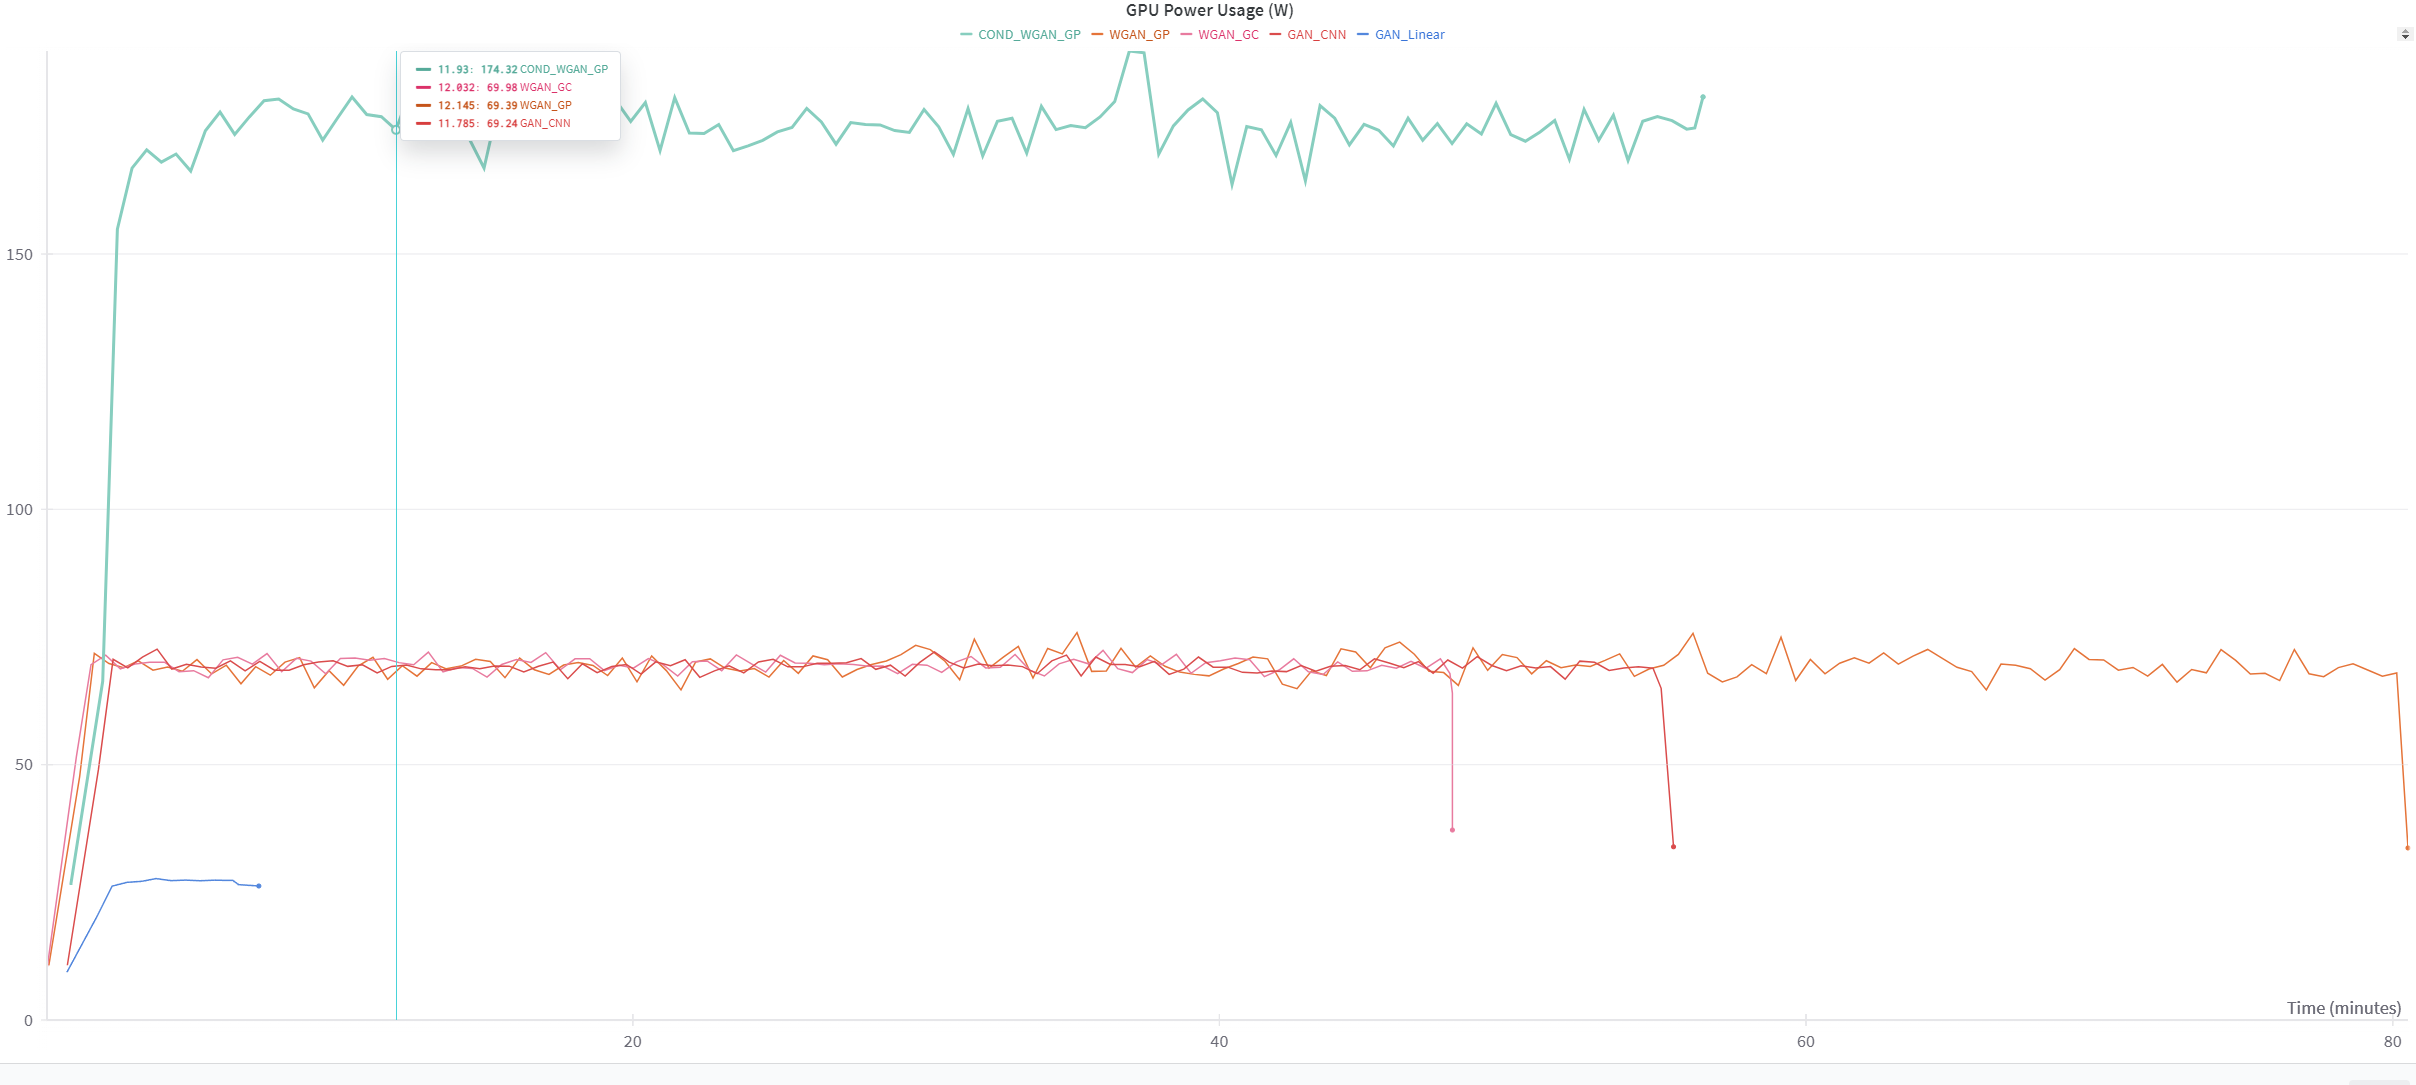